# Automatic COVID-19 detection from chest radiography

<img src="https://drive.google.com/uc?id=1h7P0hgSI5viP355fwijGWdHjK4D3CMxt" style="padding-top: 50px;width: 87%;left: 0px;margin-left: 0px;margin-right: 0px;">

A formal writeup for this project can be found on my [personal website](https://hectorcarrion.com/home/vesta).

The aim of this project is to train a model that will classify weather a given chest X-Ray presents COVID-19, Pneumonia or is Normal.

This notebook will cover:

-  Data preprocessing
-  Handling class imbalance
-  Transfer learning to retrain DenseNet121 for X-Ray image classification
-  GradCAMS visualizations

## Packages

In [3]:
import train_util as util
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

import tensorflow as tf
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras import backend as K

print("\u2022 Using TensorFlow Version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

Using TensorFlow backend.


• Using TensorFlow Version: 2.2.0-rc3
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Loading our dataset generators

The data generator idea and set split is covered on [this notebook](https://)

In [ ]:
train_df = pd.read_csv("train_small.txt", delimiter = " ")
val_df = pd.read_csv("val_small.txt", delimiter = " ")
test_df = pd.read_csv("test_small.txt", delimiter = " ")
labels = ['Normal', 'Pneumonia', 'Covid19']

Things to note:

-  We normalize the mean and standard deviation of the data
-  We shuffle the input after each epoch.
-  We set the image size to be 320px by 320px

In [5]:
train_generator = util.get_train_generator(train_df, labels)
val_generator, test_generator = util.get_test_and_valid_generator(val_df, test_df, train_df, labels)

getting train generator...
Found 2191 validated image filenames.
getting train and valid generators...
Found 2191 validated image filenames.
Found 150 validated image filenames.
Found 150 validated image filenames.


Let's have a look at what the generator gives our model during training and validation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


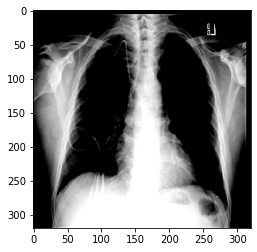

In [6]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

You may wonder if our normalization techniques have destroyed the detail in our images but it's important to notice the python warning saying we've clipped the image.

The actual values in the array range from ~-2.0 to +2.0, but pyplot.imshow() only handles the range 0...1 and clips everything else. This is why it looks like less detail to the human eye. The detail still exists.

## Handling class imbalance

Let's plot the frequency of each of the labels in our dataset.

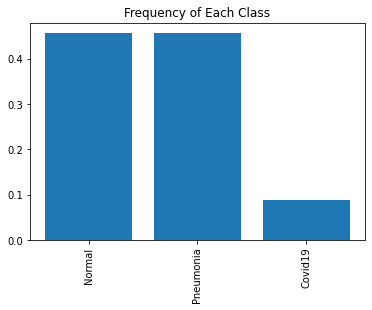

In [7]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

While we resampled the original dataset to bring these classes closer together, more work needs to be done.

We can rewrite the overall average cross-entropy loss over the entire training set $\mathcal{D}$ of size $N$ as follows: 

$$\mathcal{L}_{cross-entropy}(\mathcal{D}) = - \frac{1}{N}\big( \sum_{\text{positive examples}} \log (f(x_i)) + \sum_{\text{negative examples}} \log(1-f(x_i)) \big).$$



Let's calculate our class frequencies.

In [9]:
freq_pos, freq_neg = util.compute_class_freqs(train_generator.labels)
print(freq_pos)
print(freq_neg)

[0.4564126  0.4564126  0.08717481]
[0.5435874  0.5435874  0.91282519]


We cann see how each class have postive and negative contribution ratios. Let's visualize them.

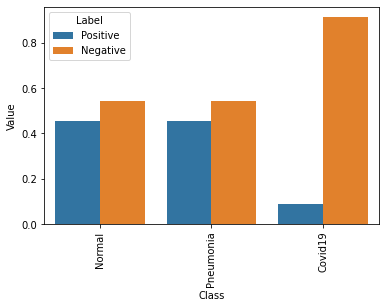

In [10]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

The contributions of positive cases is lower than that of the negative ones. We'd like them to be equal. Let's multiply by a class-specific weight factor to achieve this:

$$w_{pos} \times freq_{p} = w_{neg} \times freq_{n},$$

In [ ]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

Now that we have the weighted contributions, let's plot the contribution ratios again.

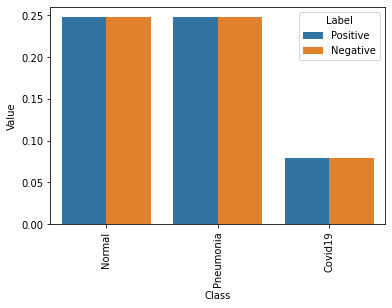

In [12]:
data = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": labels[l], "Label": "Negative", "Value": v} 
                        for l,v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

Now the positive and negative labels within each class would have the same aggregate contribution to the loss function. To finalize our loss function, a function called `get_weighted_loss()` is implemented in `train_util.py`.

Final Loss:
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

## Model architecture

Densenet is a convolutional network where each layer is connected to all other layers that are deeper in the network

-  The first layer is connected to the 3rd, 4th etc.
-  The second layer is connected to the 3rd, 4th, 5th etc.

<img src="https://drive.google.com/uc?id=1tX3hBqMmKK2naO4FfKpNj0NOMYAP6iPf" alt="DenseNet Image" width="400" align="middle"/>

Gao Huang et al. 2018 [Densely Connected Convolutional Networks](https://arxiv.org/pdf/1608.06993.pdf).

[DenseNet121](https://www.kaggle.com/pytorch/densenet121) can be loaded directly from Keras to serve as our architecture.

In [ ]:
base_model = DenseNet121(weights='./nih_weights/densenet.hdf5', include_top=False)

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer, the size of 14 was chosen to assure compatibility with
# the pretrained network
predictions = Dense(14, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)
# Compile with custom loss
model.compile(optimizer='adam', loss = util.get_weighted_loss(pos_weights, neg_weights))

We'd normally start training here as this model is already trained on ImageNet, however deeplearning.ai provides you with weights trained on 40GB+ of [NIH Chest X-Ray data](https://nihcc.app.box.com/v/ChestXray-NIHCC) as part of their homework. Let's load those instead.

In [ ]:
model.load_weights("./nih_weights/pretrained_model.h5")
x2 = model.output

predictions = Dense(len(labels), activation="softmax")(x)

model = Model(inputs=model.input, outputs=predictions)
model.compile(optimizer='adam', loss = util.get_weighted_loss(pos_weights, neg_weights))

Let's take a look at the model.

In [16]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

Let's freeze everything but the last layer of this model so that we may effectively train the classifier at the end.

In [ ]:
for layer in model.layers[:-1]:
  layer.trainable = False

model.compile(optimizer='adam', loss = util.get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])

## Training

Let's declare some callback functions for convinience.

*Note: you may choose your own hyper-parameters, these seem to work well for me.*

In [19]:
import h5py
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

best_model_file = "./vesta.h5"
best_model = ModelCheckpoint(best_model_file,
                             monitor = 'val_loss',
                             mode = 'auto',
                             verbose = 1,
                             save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.1,
                              patience = 3,
                              min_lr = 0.00001,
                              verbose = 1)

tensor_board = tbCallBack = TensorBoard(log_dir = './logs',
                                        histogram_freq = 0,
                                        write_graph = True,
                                        write_images = False)

callback_list = [reduce_lr, earlystop, best_model, tensor_board]

history = model.fit_generator(train_generator, 
                              validation_data = val_generator,
                              steps_per_epoch = 100, 
                              validation_steps = 25, 
                              epochs = 8,
                              verbose = 1,
                              callbacks = callback_list)

Epoch 1/8
  2/100 [..............................] - ETA: 15:46 - loss: 0.7971 - accuracy: 0.5000

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.400243). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 761s 8s/step - loss: 0.5484 - accuracy: 0.8074 - val_loss: 0.3342 - val_accuracy: 0.6974

Epoch 00001: val_loss improved from inf to 0.33425, saving model to ./deepX.h5
Epoch 2/8
100/100 [==============================] - 281s 3s/step - loss: 0.4096 - accuracy: 0.8562 - val_loss: 0.3641 - val_accuracy: 0.8216

Epoch 00002: val_loss did not improve from 0.33425
Epoch 3/8
100/100 [==============================] - 41s 412ms/step - loss: 0.3875 - accuracy: 0.8449 - val_loss: 0.4556 - val_accuracy: 0.7395

Epoch 00003: val_loss did not improve from 0.33425
Epoch 4/8
100/100 [==============================] - 41s 408ms/step - loss: 0.3789 - accuracy: 0.8500 - val_loss: 0.3743 - val_accuracy: 0.8297

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_loss did not improve from 0.33425
Epoch 5/8
100/100 [==============================] - 42s 421ms/step - loss: 0.3544 - accuracy: 0.8580 - val_loss: 0.2923

Let's plot accuracy and loss

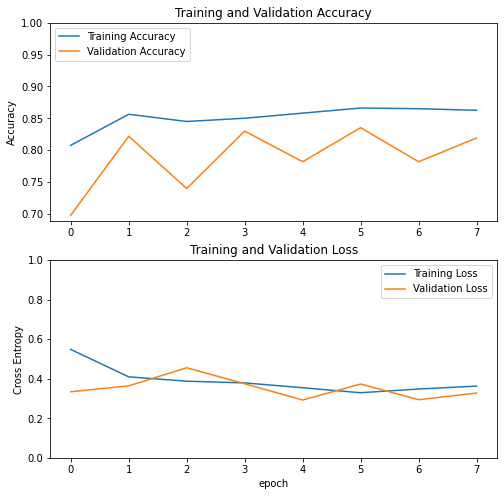

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine tunning

Let's take a look to see how many layers are in the base model

In [21]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  427


I've decided to unfreeze the last 100 layers for fine tuning.

In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 327

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[fine_tune_at:]:
  layer.trainable = True

# When recompiling the model, I've swapped a custom Adam optimizer in with a lower learning rate and amsgrad variant
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad = True),
              loss = util.get_weighted_loss(pos_weights, neg_weights),
              metrics = ['accuracy'])

best_fine_file = "./vesta-fine.h5"
best_fine_model = ModelCheckpoint(best_fine_file,
                             monitor = 'val_loss',
                             mode = 'auto',
                             verbose = 1,
                             save_best_only = True)

We're ready to continue training, this time starting from the best epoch from the inintal training.

In [25]:
best_epoch = 5
history_fine = model.fit_generator(train_generator, 
                              validation_data = val_generator,
                              steps_per_epoch = 100, 
                              validation_steps = 25, 
                              epochs = 16,
                              initial_epoch = history.epoch[best_epoch],
                              verbose = 1,
                              callbacks = [best_fine_model, earlystop])

Epoch 6/15
100/100 [==============================] - 58s 584ms/step - loss: 0.3399 - accuracy: 0.8737 - val_loss: 0.2643 - val_accuracy: 0.8053

Epoch 00006: val_loss improved from inf to 0.26425, saving model to ./deepXFine.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 7/15
100/100 [==============================] - 42s 419ms/step - loss: 0.3389 - accuracy: 0.8637 - val_loss: 0.3135 - val_accuracy: 0.8324

Epoch 00007: val_loss did not improve from 0.26425
Epoch 8/15
100/100 [==============================] - 44s 441ms/step - loss: 0.3293 - accuracy: 0.8687 - val_loss: 0.2441 - val_accuracy: 0.8053

Epoch 00008: val_loss improved from 0.26425 to 0.24409, saving model to ./deepXFine.h5
Epoch 9/15
100/100 [==============================] - 43s 434ms/step - loss: 0.3399 - accuracy: 0.8643 - val_loss: 0.3281 - val_accuracy: 0.8297

Epoch 00009: val_loss did not improve from 0.24409
Epoch 10/15
100/100 [==============================] - 44s 442ms/step - loss: 0.3106 - accuracy: 0.8806 - val_loss: 0.2733 - val_accuracy: 0.8105

Epoch 00010: val_loss did not improve from 0.24409
Epoch 11/15
100/100 [==============================] - 42s 422ms/step - loss: 0.2974 - accuracy: 0.8813 - val_loss: 0.3250 - val_accuracy: 0.8432

Epoch 00011: val_loss did no

Let's plot loss once more.

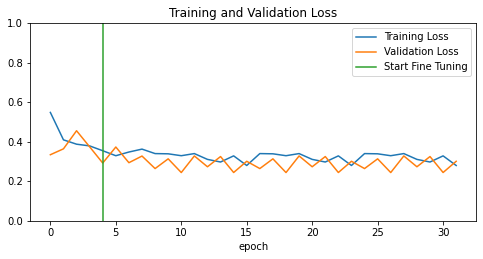

In [29]:
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([best_epoch-1,best_epoch-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

I experimented with different epochs and learning rates, eventually I was happy with the results after 50 epochs of fine tunning. [As shown here.](https://)

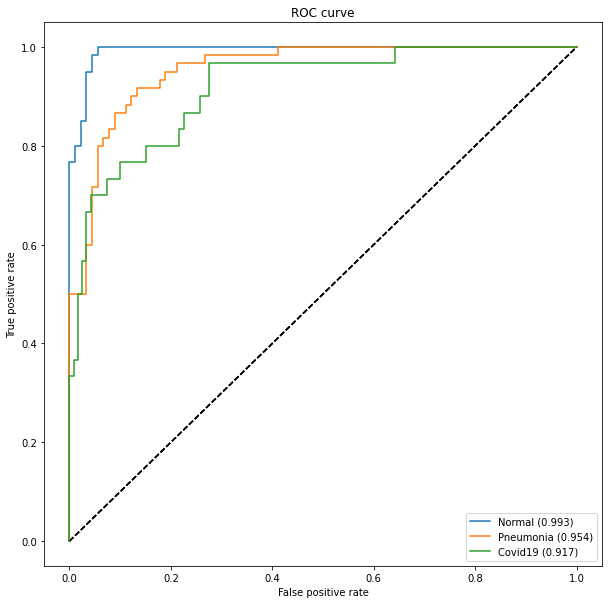

In [34]:
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))
auc_rocs = util.get_roc_curve(labels, predicted_vals, test_generator)

Once we're happy with the performance let's move on to visualizations.

## Visualizations

Let's use [GradCAM's](https://arxiv.org/abs/1610.02391) technique to produce a heatmap highlighting the important regions in the image for predicting the class.

While this technique will not provide a full explanation for the models behavior, it's still a good tool for debugging our model (checking to see if it's looking in the right areas) and may help an expert validate such a prediction.

Loading original image
Generating gradcam for class Normal
Generating gradcam for class Pneumonia
Generating gradcam for class Covid19


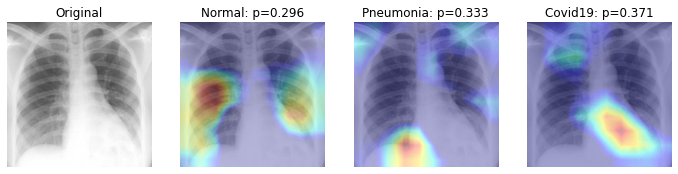

In [35]:
df = pd.read_csv("train_small.txt", delimiter = " ")
IMAGE_DIR = "data/"
labels_to_show = np.take(labels, np.argsort(auc_rocs)[::-1])[:]

util.compute_gradcam(model, 'SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Normal
Generating gradcam for class Pneumonia
Generating gradcam for class Covid19


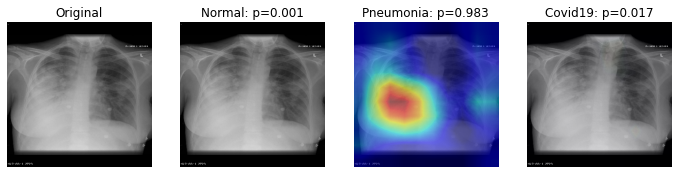

In [42]:
util.compute_gradcam(model, 'pneumonia-7.jpg', IMAGE_DIR, df, labels, labels_to_show)

Loading original image
Generating gradcam for class Normal
Generating gradcam for class Pneumonia
Generating gradcam for class Covid19


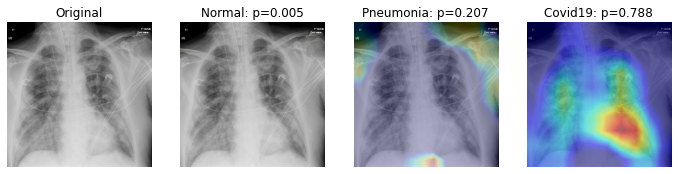

In [37]:
util.compute_gradcam(model, 'covid-19-pneumonia-23-day9.jpg', IMAGE_DIR, df, labels, labels_to_show)

Looking good, our model seems to focus on the right areas. Especially for the COVID examples.

Let's move on to [Evaluation.](https://github.com/hectorcarrion/vesta/blob/master/Evaluation.ipynb)

### Optional: saving predictions file

Run this if you'd like to save the predictions, I have set it to generate predictions for our test set but this can be adjusted for the other sets.

In [ ]:
test_predictions = []

for row in test_df.values:
  test_prediction = []

  i = 0
  for item in row:
    if i < 5:
      test_prediction.append(item)
    i += 1

  predictions = util.load_predict(test_prediction[1], IMAGE_DIR, df)
  for pred in predictions[0]:
    test_prediction.append(pred)

  test_predictions.append(test_prediction)

outputF = open("test_preds.txt","w+")

# Column names:
outputF.write(("PatientID" + "\t" + "Image" + "\t" + "Normal" + "\t" + "Pneumonia"
               + "\t" + "Covid19" + "\t" + "Normal_pred" + "\t" + "Pneumonia_pred"
               + "\t" + "Covid19_pred") + "\n")

for data in test_predictions:
  # Writing each line
  outputF.write((data[0] + "\t" + data[1] + "\t" + str(data[2]) + "\t" + str(data[3])
                 + "\t" + str(data[4]) + "\t" + str(data[5]) + "\t" + str(data[6])
                 + "\t" + str(data[7]) + "\n"))

outputF.close()